In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

## data load

In [2]:
gpu_id = 3
num_cores = 4
torch.cuda.set_device(gpu_id)

In [3]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')  # path to saved models
print(data_pth)  # confirm data path
print(model_pth) # confirm model path

/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets
/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss


In [4]:
bs=8
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [5]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [6]:
mode = 'L'
norm = True
noise = False
cutout = False # Maybe?

In [7]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


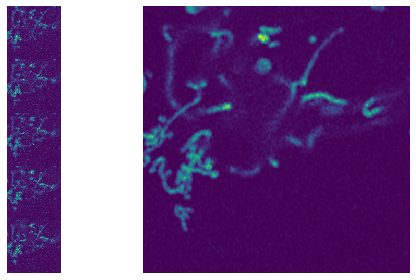

In [8]:
data.show_batch(rows=1)

## training

In [9]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

## original

In [10]:
save_name = 'fluo_pssr_100epoch'

In [11]:
learn_pssr = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                           loss_func=F.mse_loss, metrics=metrics,
                           model_dir=model_pth, wd=wd)

In [12]:
learn_pssr.fit_one_cycle(cycles, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,time
0,0.137772,0.195749,24.984468,0.158606,06:32
1,0.114864,0.164721,25.736408,0.210670,06:41
2,0.102227,0.162683,25.799925,0.234303,06:38
3,0.097626,0.162046,25.815752,0.242290,06:40
4,0.098093,0.130001,26.755878,0.266591,06:37
5,0.093446,0.135996,26.562412,0.272804,06:39
6,0.090992,0.124315,26.947929,0.283531,06:37
7,0.092949,0.125922,26.898357,0.288604,06:39
8,0.087811,0.116309,27.233047,0.295581,06:39
9,0.088244,0.116851,27.215542,0.297220,06:39


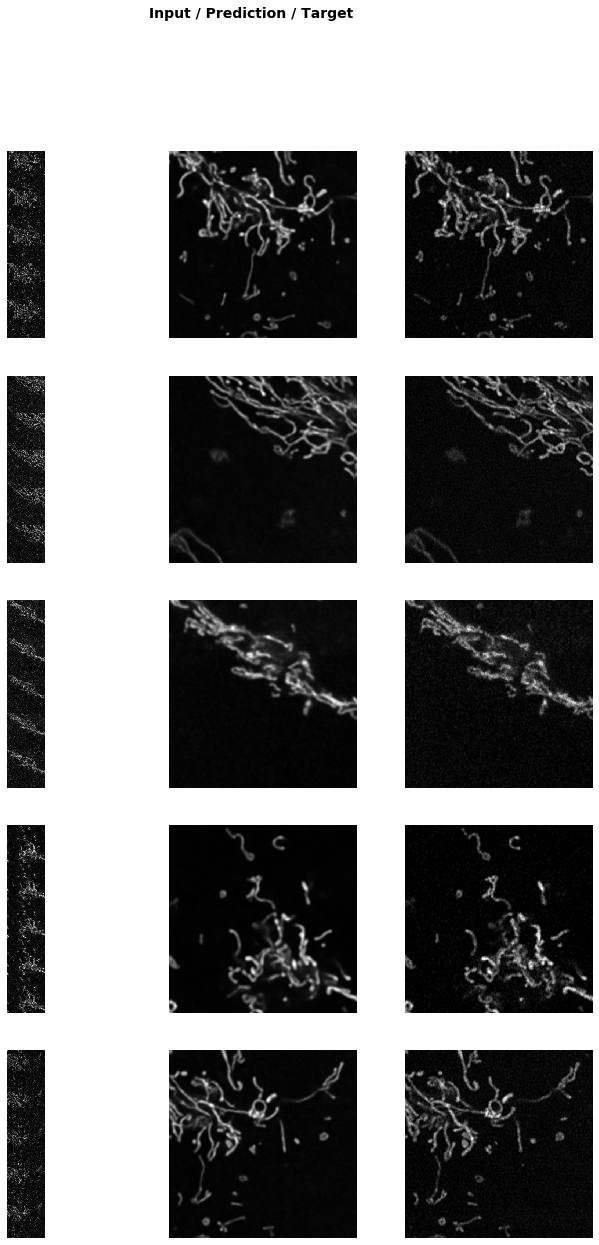

In [13]:
learn_pssr.show_results(rows=5, cmap='gray')

In [14]:
learn_pssr.save(save_name)
print(f'saved: {save_name}')

saved: fluo_pssr_100epoch
